# Project 4 - QR Code Reader

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from decoder import decode
rcParams = plt.rcParams
plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['text.color'] = 'white'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])


c:\Users\danie\anaconda3\envs\pyt37\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [2]:
class RunLength():
    def __init__(self, x0, y0, begin_color):
        self.points = [(x0,y0)]
        self.currColor = begin_color
        self.dist = []
        self.len = 0

    def newColor(self, x, y, color):
        self.currColor = color
        self.dist.append(((x - self.points[-1][0])**2 + (y-self.points[-1][1])**2)**0.5)
        self.points.append((x,y))
        self.len += 1

def get_img(img_path):
    qr_code = cv2.imread(img_path)
    qr_code_gray = cv2.cvtColor(qr_code, cv2.COLOR_BGR2GRAY)
    qr_code_gray = np.reshape((qr_code_gray >= 100), qr_code_gray.shape)

    return qr_code, qr_code_gray

def find_ratio(run_length, ratio_thresh):
    centers = []
    for i in range(run_length.len-4):
        dist = run_length.dist[i]
        if run_length.dist[i+1] <= (dist - ratio_thresh) or run_length.dist[i+1] >= (dist + ratio_thresh)  or \
            run_length.dist[i+2] <= 3*(dist - ratio_thresh) or run_length.dist[i+2] >= 3*(dist + ratio_thresh) or \
            run_length.dist[i+3] <= (dist - ratio_thresh) or run_length.dist[i+3] >= (dist + ratio_thresh) or \
            run_length.dist[i+4] <= (dist - ratio_thresh) or run_length.dist[i+4] >= (dist + ratio_thresh):
                # one of the distances is not within the threshold
                # so skip the rest of the loop
                continue
        else: # The 5 distances match the ratio
            x = (run_length.points[i+2][0] + run_length.points[i+3][0])//2
            y = (run_length.points[i+2][1] + run_length.points[i+3][1])//2
            centers.append((y,x))
    return centers

def get_corners(img, ratio_thresh):
    runs = []
    for x in range(0, img.shape[0]):
        run_length_vert = RunLength(0, x, img[0][x])
        run_length_hor = RunLength(x, 0, img[x][0])
        for y in range(img.shape[1]):
            if img[y][x] != run_length_vert.currColor:
                run_length_vert.newColor(y, x, img[y][x])
            if img[x][y] != run_length_hor.currColor:
                run_length_hor.newColor(x, y, img[x][y])
        run_length_vert.newColor(y, x+1, img[y][x])
        run_length_hor.newColor(x, y+1, img[x][y])
        runs.append(run_length_vert)
        runs.append(run_length_hor)

    centers = []
    for run in runs:
        centers.extend(find_ratio(run, ratio_thresh))
    return centers

def get_corner_centers(img_path, accum_thresh=4, ratio_thresh=5):
    qr_code, qr_code_gray = get_img(img_path)
    centers = get_corners(qr_code_gray, ratio_thresh)

    img_accumulator = np.zeros(qr_code_gray.shape)
    for center in centers:
        img_accumulator[center[1]][center[0]] += 1

    centers_img = img_accumulator > accum_thresh
    centers = np.argwhere(centers_img > 0)

    centers_new = []
    for center in centers:
        centers_new.append([center[1], center[0]])

    return qr_code, centers_new, qr_code_gray

def find_fourth_point(corners, x_dim, y_dim):
    dist_x = int(x_dim - corners[0][0])
    dist_y = int(y_dim - corners[0][1])
    return np.array([corners[0], corners[1], corners[2], np.array([dist_x, dist_y])])

def scale_rotate(qr_code, corners):
    qr_code_al, corners_al, gray_al = get_corner_centers("Images\\aligned.jpg", accum_thresh=1, ratio_thresh=5)

    four_corners = find_fourth_point(corners, qr_code.shape[0], qr_code.shape[1])
    four_corners_al = find_fourth_point(corners_al, qr_code_al.shape[0], qr_code_al.shape[1])

    corner_output = qr_code.copy()
    for corner in corners:
        corner_output[corner[1]][corner[0]] = (0,255,0)

    four_corners = np.array(four_corners, dtype=np.float32).reshape((-1,1,2))
    four_corners_al = np.array(four_corners_al, dtype=np.float32).reshape((-1,1,2))

    M, _ = cv2.findHomography(four_corners, four_corners_al)
    out = cv2.cvtColor(cv2.warpPerspective(qr_code,M,gray_al.shape), cv2.COLOR_BGR2GRAY)

    thresh = np.reshape((out >= 200), gray_al.shape) 
    return corner_output, thresh

def verify_block_size(block_size):
    valid = [21, 25, 29, 33]
    ok = []
    for v in valid:
        ok.append((v-block_size))
    return valid[ok.index(min(ok))]

def verify_ps(ps, lengths, thresh=2):
    sum = 0
    ctr = 0
    for length in lengths:
        if (ps+thresh) >= length and (ps-length) <= length:
            sum += length
            ctr += 1
    return round(sum/ctr)
    
def get_block_size(img):
    length1 = []
    curr_color1 = img[25][0]
    curr_len1 = 0

    length2 = []
    curr_color2 = img[140][0]
    curr_len2 = 0

    for x in range(0, img.shape[1]):
        curr_len1 += 1
        curr_len2 += 1
        if img[25][x] != curr_color1:
            curr_color1 = img[25][x]
            length1.append(curr_len1)
            curr_len1 = 0

    ps = round(max(set(length1), key = length1.count)) # + max(set(length2), key = length2.count))/2)
    block_size = img.shape[1]//ps
    # print(block_size, ps)
    block_size = verify_block_size(block_size)
    ps = verify_ps(ps, length1)
    # print(block_size, ps)
    return block_size, ps

def discretize_img(transformed_code, block_size, ps):
    disc_code = np.zeros((block_size,block_size))

    for x in range(0,transformed_code.shape[0], ps):
        for y in range(0,transformed_code.shape[1], ps):
            disc_block = []
            for i in range(0,ps-1):
                for j in range(0,ps-1):
                    disc_block.append(transformed_code[min(x+i,transformed_code.shape[0]-1)][min(y+j,transformed_code.shape[1]-1)])
            disc_code[min(x//(ps), block_size-1)][min(y//(ps), block_size-1)] = (sum(disc_block)/ps**2)>0.5

    return disc_code

def run_full(img_path, accum_thresh=1, ratio_thresh=5):
    qr_code, corners, gray = get_corner_centers(img_path, accum_thresh=accum_thresh, ratio_thresh=ratio_thresh) # (21,21) # works great
    four_corners, transformed_code = scale_rotate(qr_code, corners)
    block_size, ps = get_block_size(transformed_code)
    disc_code = discretize_img(transformed_code, block_size, ps)

    plt.subplot(141)
    plt.imshow(qr_code)
    # just_title("Original Image")

    plt.subplot(142)
    plt.imshow(four_corners)
    # just_title("Corners Overlaid")

    plt.subplot(143)
    plt.imshow(transformed_code, cmap='gray')
    # just_title("Cropped and Rotated")

    # plt.subplot(144)
    # plt.imshow(disc_code, cmap='gray')
    # just_title("Discretized Code")

    return disc_code

http://byu.edu


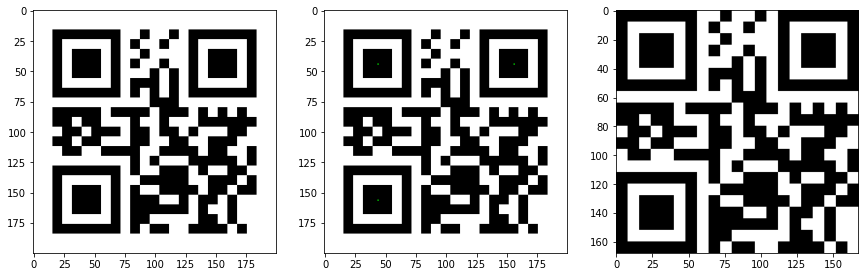

In [3]:
disc_code1 = run_full("QR_codes\\test1.png", accum_thresh=1, ratio_thresh=5)
output1 = decode(disc_code1)
print(output1)

http://byu.edu


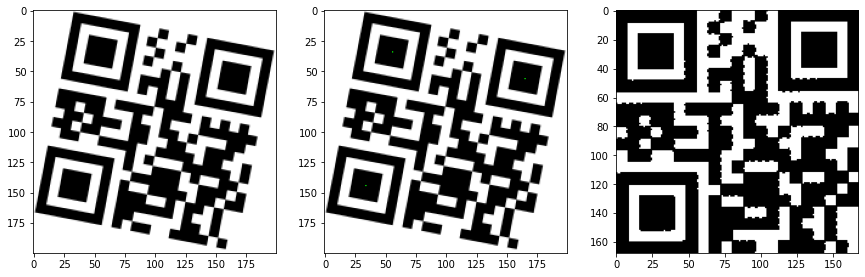

In [7]:
disc_code2 = run_full("QR_codes\\test2.png", accum_thresh=1, ratio_thresh=4)
output2 = decode(disc_code2)
print(output2)

KeyError: 'Parsed Result'

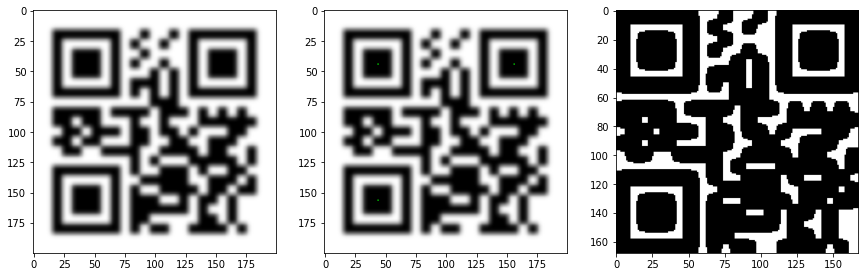

In [8]:
disc_code3 = run_full("QR_codes\\test3.png", accum_thresh=1, ratio_thresh=5)
output3 = decode(disc_code3)
print(output3)
# could not get this one to work

http://byu.edu


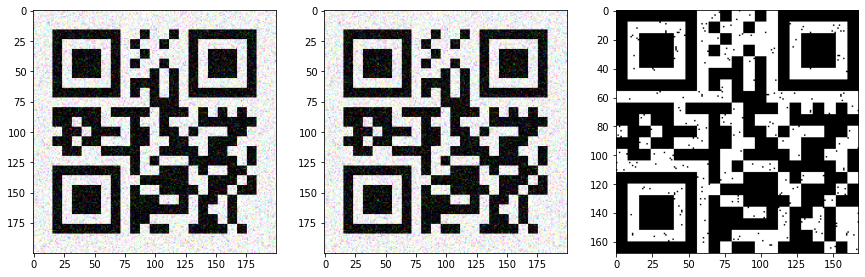

In [9]:
disc_code4 = run_full("QR_codes\\test4.png", accum_thresh=1, ratio_thresh=5)
output4 = decode(disc_code4)
print(output4)

KeyError: 'Parsed Result'

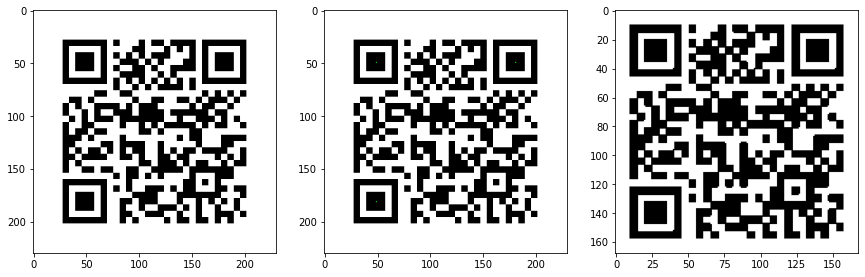

In [10]:
disc_code5 = run_full("QR_codes\\test5.png", accum_thresh=1, ratio_thresh=2)
output5 = decode(disc_code5)
print(output5)
# could not get this one to work

### Part D: Decoding

## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

In [ ]:
# SEE RESULTS ABOVE

# image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(image,cmap="gray");plt.show()

# image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(image,cmap="gray");plt.show()

# image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(image,cmap="gray");plt.show()

# image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(image,cmap="gray");plt.show()

# image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(image,cmap="gray");plt.show()


http://byu.edu


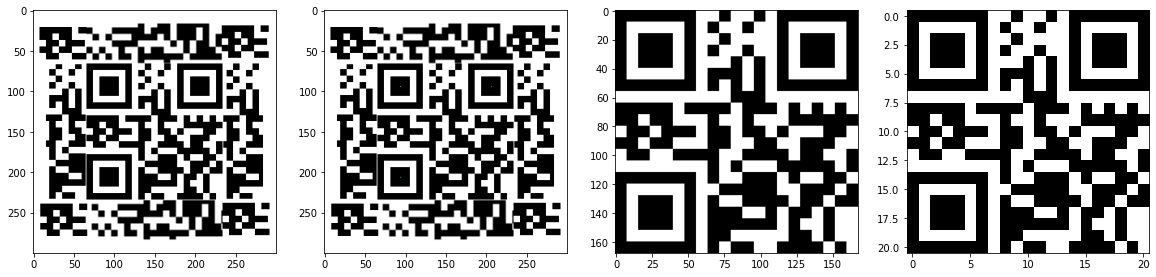

In [ ]:
challenge3 = run_full("QR_codes/challenge3.png", accum_thresh=1, ratio_thresh=2)
out_chall3 = decode(challenge3)
print(out_chall3)